## Preparation

In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\BRCA',
 'D:\\anaconda\\envs\\STAligner\\python310.zip',
 'D:\\anaconda\\envs\\STAligner\\DLLs',
 'D:\\anaconda\\envs\\STAligner\\lib',
 'D:\\anaconda\\envs\\STAligner',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python310\\site-packages',
 'D:\\anaconda\\envs\\STAligner\\lib\\site-packages',
 'D:\\anaconda\\envs\\STAligner\\lib\\site-packages\\staligner-1.0.0-py3.10.egg',
 'D:\\anaconda\\envs\\STAligner\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\STAligner\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\STAligner\\lib\\site-packages\\Pythonwin']

In [2]:
#-*- coding : utf-8-*-
# coding:unicode_escape
import warnings
warnings.filterwarnings("ignore")

# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "D:\\anaconda\envs\STAligner\Lib\R"
os.environ['R_USER'] = "D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2"

In [3]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

In [4]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(used_device)

cuda:0


In [5]:
sample_names = ["bc1160920F","bc1142243F"]
input_dir = 'G:/dataset/3_BRCA/input/'
output_dir = 'G:/dataset/3_BRCA/output/STAligner/'
experiment_name = 'BRCA'

In [6]:
# import pandas as pd
# section_ids = ['Anterior1','Anterior2','Posterior1','Posterior2']
# for dataset in section_ids:
#     adata_label = pd.read_csv(input_dir + dataset + '/truth.csv', index_col=0)
#     types = adata_label['celltype'].unique().tolist()
#     print(len(types))

## Load Data

In [7]:
from scipy import sparse

Batch_list = []
adj_list = []

for section_id in sample_names:
    print(section_id)
    # input_path = input_dir + section_id
    # adata = sc.read_visium(path=input_path, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    # adata.var_names_make_unique(join="++")

    adata = sc.read_h5ad(input_dir + section_id + '.h5ad')
    df = adata.obs[['x','y']].astype('float32')
    adata.obsm['spatial'] = df.values
    
    adata.obs['Ground Truth'] = adata.obs['Classification']
    adata = adata[~pd.isna(adata.obs['x'])]
    # adata_list.append(adata)
    
    # make spot name unique
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=2)
    # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

bc1160920F
------Calculating spatial graph...
The graph contains 19100 edges, 4895 cells.
3.9019 neighbors per cell on average.
bc1142243F
------Calculating spatial graph...
The graph contains 18718 edges, 4784 cells.
3.9126 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [8]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=sample_names)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (9679, 1944)


## Concat the spatial network for multiple slices

In [9]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(sample_names)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [10]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

STAligner(
  (conv1): GATConv(1944, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1944, heads=1)
)
Pretrain with STAGATE...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.33it/s]


Train with STAligner...


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|████████████████                                                                | 100/500 [00:11<00:41,  9.70it/s]

Update spot triplets at epoch 600


 40%|████████████████████████████████                                                | 200/500 [00:22<00:30,  9.73it/s]

Update spot triplets at epoch 700


 60%|████████████████████████████████████████████████                                | 300/500 [00:34<00:20,  9.69it/s]

Update spot triplets at epoch 800


 80%|████████████████████████████████████████████████████████████████                | 400/500 [00:46<00:10,  9.76it/s]

Update spot triplets at epoch 900


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.63it/s]

CPU times: total: 1min 58s
Wall time: 1min 52s


# save embedding

In [11]:
# save embedding
np.savetxt(output_dir + experiment_name + '_STAligner.csv', adata_concat.obsm['STAligner'], delimiter=",")
np.savetxt(output_dir + experiment_name + '_STAGATE.csv', adata_concat.obsm['STAGATE'], delimiter=",")

## Clustering

In [12]:
adata_concat

AnnData object with n_obs × n_vars = 9679 × 1944
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth', 'slice_name', 'batch_name'
    uns: 'edgeList'
    obsm: 'spatial', 'STAGATE', 'STAligner'

In [13]:
# import seaborn as sns
# slice_colors = sns.color_palette(n_colors = 6).as_hex()
series = adata_concat.obs['Ground Truth'].astype("category")

celltype_num = len(series.value_counts().index)
celltypes = series.value_counts().index.tolist()
print(celltype_num)

import seaborn as sns
colors = sns.color_palette(n_colors = celltype_num).as_hex()

11


In [14]:
num_cluster = celltype_num

In [15]:
from STAligner import ST_utils
ST_utils.mclust_R(adata_concat, num_cluster=num_cluster, used_obsm='STAligner')
# adata_concat = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 9679 × 1944
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth', 'slice_name', 'batch_name', 'mclust'
    uns: 'edgeList'
    obsm: 'spatial', 'STAGATE', 'STAligner'

In [16]:
from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))

mclust, ARI = 0.071


## Visualization

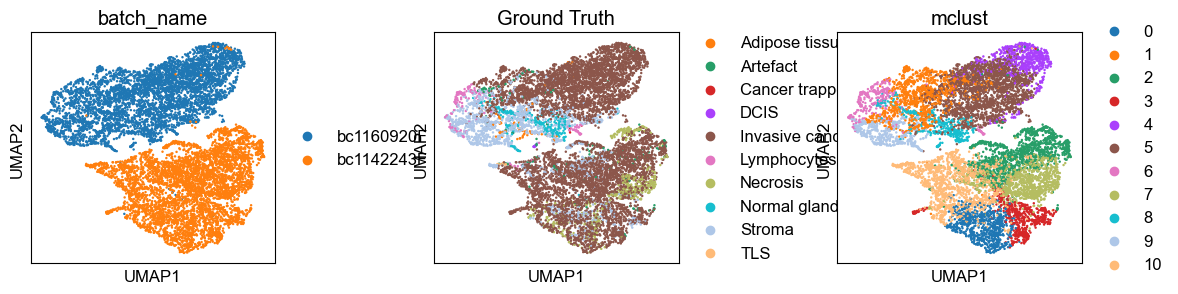

In [17]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

# section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color = sns.color_palette(n_colors = len(sample_names)).as_hex()
section_color_dict = dict(zip(sample_names, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
adata_concat.obs['mclust'] = pd.Series(ST_utils.match_cluster_labels(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3,
           wspace=0.5, show=False)

plt.savefig(output_dir + experiment_name + '_umap.png', dpi=300)

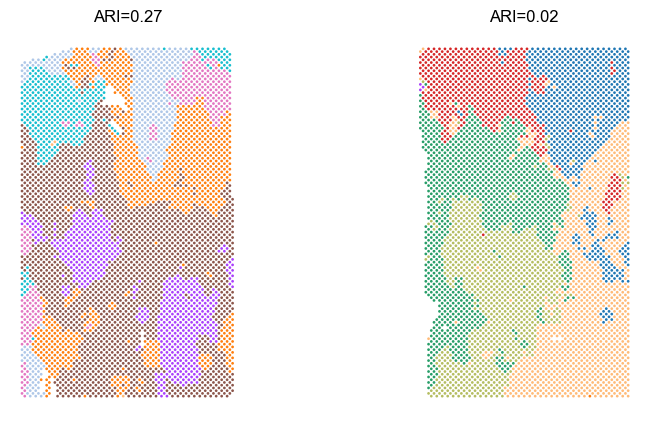

In [18]:
Batch_list = []
for section_id in sample_names:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 1
title_size = 12
ARI_list = []
for bb in range(len(Batch_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, len(Batch_list), figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)

plt.savefig(output_dir + experiment_name + '_ARI.png', dpi=300)
plt.show()

# save h5ad

In [19]:
print(type(adata_concat))
print(adata_concat.obsm)
print(adata_concat)

adata_concat.obs = adata_concat.obs.astype('str')
#  tuple 不能保存为h5ad
adata_concat.uns['edgeList'] = list(adata_concat.uns['edgeList'])

print(adata_concat.isbacked)
adata_concat.filename = output_dir + experiment_name + '.h5ad'
print(adata_concat.isbacked)

<class 'anndata._core.anndata.AnnData'>
AxisArrays with keys: spatial, STAGATE, STAligner, X_umap
AnnData object with n_obs × n_vars = 9679 × 1944
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth', 'slice_name', 'batch_name', 'mclust'
    uns: 'edgeList', 'neighbors', 'umap', 'batch_name_colors', 'Ground Truth_colors', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'STAligner', 'X_umap'
    obsp: 'distances', 'connectivities'
False
True
